# 🔍 Introduction
Welcome to my notebook for the January 2025 edition of the Tabular Playground Series! In this challenge, the task is to predict the number of calories burned during a workout, using a synthetically-generated dataset designed to reflect real-world patterns.

This notebook follows a full machine learning pipeline, starting with Exploratory Data Analysis (EDA) to understand the structure and key patterns in the dataset. Based on initial findings, I set up a robust preprocessing pipeline and explore a range of models, including:
- XGBoost (baseline, no feature engineering)
- Linear Regression
- Neural Network
- CatBoost
- LightGBM

To better capture the distribution and scale of the target variable, I train models on both the log-transformed calories and calories per minute, motivated by the observed importance of workout duration.

The final step involves ensembling the models using a Ridge Regression meta-model, aiming to combine the strengths of individual learners.

The notebook concludes with an analysis of:
- Model performance across different algorithms
- Feature importance
- Contribution of each base model to the final ensemble

Let’s dive in!

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import torch
import torch.nn as nn

# Disable warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option("display.max_columns", 500)

from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Exploratory data analysis

In [2]:
# Load data
df_train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv", index_col="id")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv", index_col="id")

print(f"df_train: {df_train.shape}, df_test: {df_test.shape}\n")
df_train.head()

df_train: (750000, 8), df_test: (250000, 7)



,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
# Set color scheme
colors = sns.color_palette("coolwarm")
colors_2 = [colors[0], colors[-1]]

## Missing values

In [4]:
missing_train = df_train.isna().sum().sum()
missing_test = df_test.isna().sum().sum()

print(f"df_train missing values: {missing_train}")
print(f"df_test missing values: {missing_test}")

df_train missing values: 0
df_test missing values: 0


## Target distribution: Calories

We begin by examining the distribution of the target variable, Calories. The distribution is notably right-skewed and the distribution appears similar for both men and women.

Given that the competition is evaluated using Root Mean Squared Logarithmic Error (RMSLE), it's important to align our modeling approach with the evaluation metric. One common strategy is to apply a log transformation to the target variable and then optimize using the standard Root Mean Squared Error (RMSE) during training. This approach often results in better alignment with RMSLE, though it's worth noting that:

⚠️ Log-transforming the target is not intended to normalize the distribution, but rather to enable training with RMSE in a way that is compatible with log-scale evaluation.

This transformation ensures that prediction errors on smaller values are penalized proportionally more, which mirrors the behavior of RMSLE and can lead to more robust model performance.

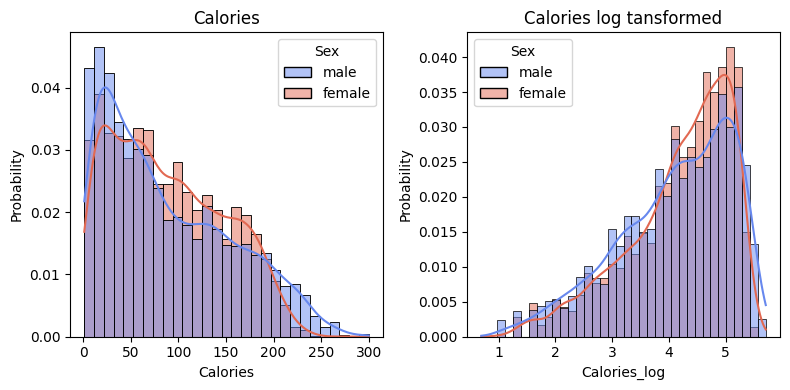

In [5]:
df_train["Calories_log"] = np.log1p(df_train["Calories"])
df_subset = df_train.sample(frac=1e-2, random_state=2025)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(x=df_subset["Calories"],
             hue=df_subset["Sex"], palette=colors_2,
             stat="probability", kde=True, ax=axes[0])
axes[0].set_title("Calories")

sns.histplot(x=df_subset["Calories_log"],
             hue=df_subset["Sex"], palette=colors_2,
             stat="probability", kde=True, ax=axes[1])
axes[1].set_title("Calories log tansformed")

plt.tight_layout()
plt.show()

## ⏱️ Calories per Minute
Given the strong influence of Duration on total calories burned, we explore the derived feature Calories per Minute as a normalized measure of workout intensity. By plotting this metric, we can better understand the variability in energy expenditure independent of workout length.

The distribution of Calories per Minute reveals a consistent trend across both men and women, indicating that the underlying relationship between intensity and calorie burn is similar across genders. However, the male data exhibits higher variance.

Due to its ability to capture intensity-adjusted calorie burn, Calories per Minute will also be used as an alternative target variable in model training. This may help the model better generalize and reduce its dependence on duration as the dominant predictor.

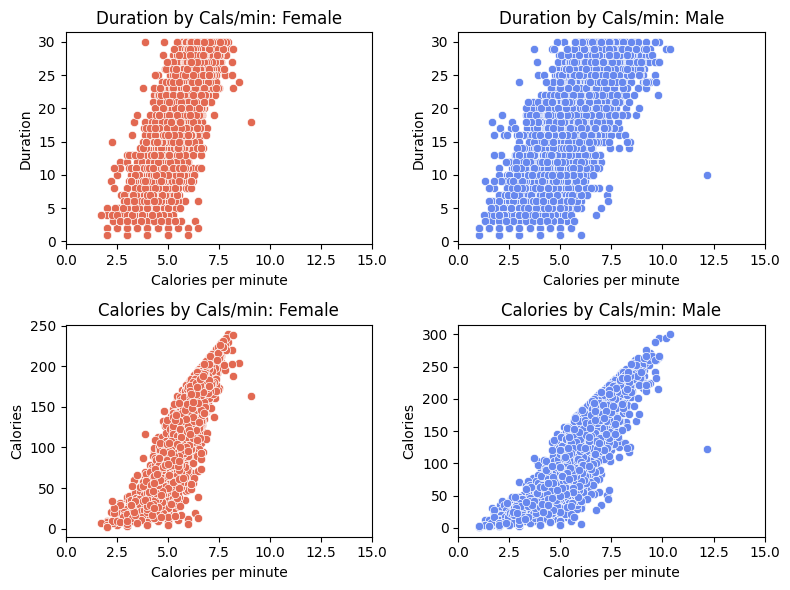

In [6]:
df_train["Cals_minute"] = df_train["Calories"] / df_train["Duration"]
df_subset = df_train.sample(frac=1e-2, random_state=2025)

df_subset_female = df_subset[df_subset["Sex"]=="female"]
df_subset_male = df_subset[df_subset["Sex"]=="male"]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
sns.set_style("whitegrid", {'axes.grid' : False})

# 1. Duration
sns.scatterplot(x=df_subset_female["Cals_minute"], y=df_subset_female["Duration"],
               ax=axes[0], color=colors_2[1])
axes[0].set_xlim(0, 15)
axes[0].set_xlabel("Calories per minute")
axes[0].set_title("Duration by Cals/min: Female")

sns.scatterplot(x=df_subset_male["Cals_minute"], y=df_subset_male["Duration"],
               ax=axes[1], color=colors_2[0])
axes[1].set_xlim(0, 15)
axes[1].set_xlabel("Calories per minute")
axes[1].set_title("Duration by Cals/min: Male")

# 2. Calories
sns.scatterplot(x=df_subset_female["Cals_minute"], y=df_subset_female["Calories"],
               ax=axes[2], color=colors_2[1])
axes[2].set_xlim(0, 15)
axes[2].set_xlabel("Calories per minute")
axes[2].set_title("Calories by Cals/min: Female")

sns.scatterplot(x=df_subset_male["Cals_minute"], y=df_subset_male["Calories"],
               ax=axes[3], color=colors_2[0])
axes[3].set_xlim(0, 15)
axes[3].set_xlabel("Calories per minute")
axes[3].set_title("Calories by Cals/min: Male")

plt.tight_layout()
plt.show()

## 🔗 Exploring Numeric Features: Correlation with Calories
To gain an initial understanding of how the numeric features relate to the target variable, we visualize the correlation matrix. This helps highlight potential relationships between predictors and the number of calories burned.

Among the features, we observe notably strong correlations with Duration, Heart_Rate, and Body_Temp, suggesting that these variables play a significant role in determining caloric expenditure. However, it's important to recognize that:

⚠️ These correlations do not imply linear relationships—they simply reflect monotonic trends captured by Pearson correlation. Non-linear models may be better suited to uncover the true functional dependencies between these features and the target.


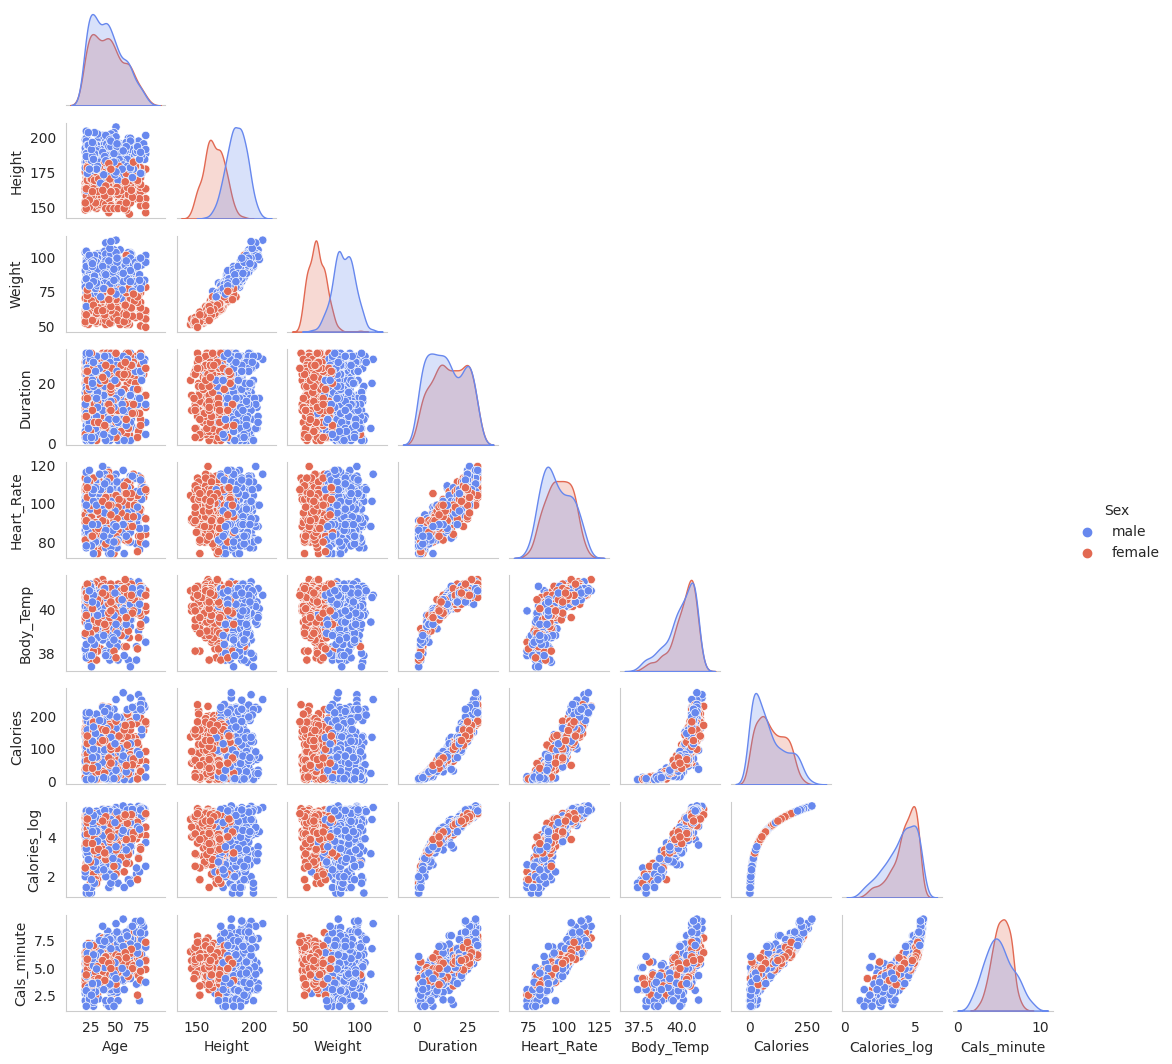

In [7]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_train.sample(frac=1e-3, random_state=2025), 
             hue="Sex", palette=colors_2,
             height=1.2, corner=True)

plt.show()

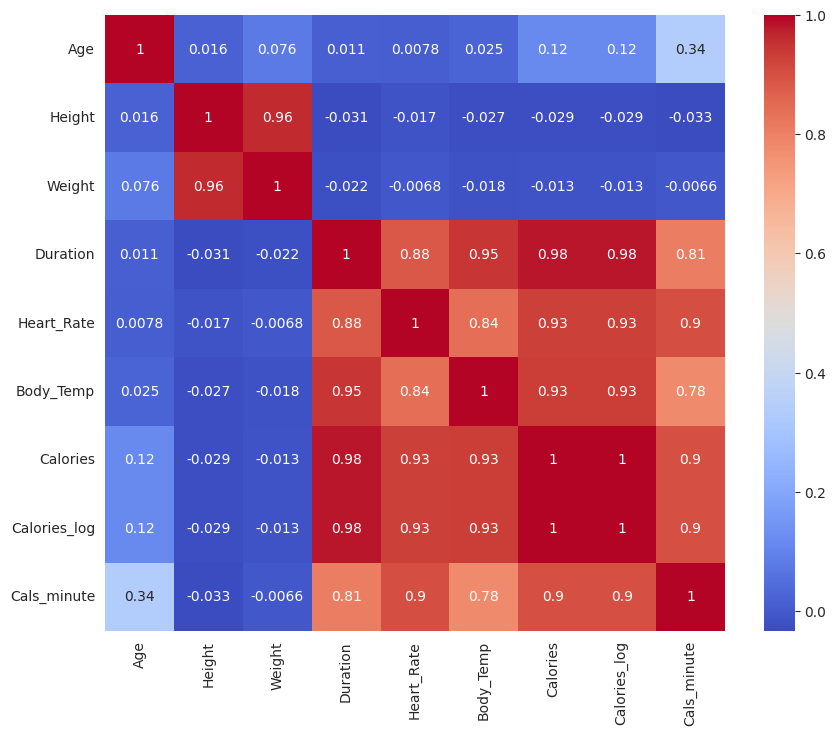

In [8]:
corr_matrix = df_train.corr(method="spearman", numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.show()

## ⚖️ Body Mass Index (BMI): Standardizing Across Sex
BMI (Body Mass Index) is a classical health metric often associated with energy expenditure. We calculate BMI using the standard formula:

BMI = Weight (kg) / Height (m)²
 
Initial analysis shows that males have a higher average BMI than females in this dataset. This discrepancy can introduce a sex-specific bias in how BMI relates to calorie burn.

To account for this, we normalize BMI within each sex group by computing the Z-score (standard score). This transformation centers and scales BMI separately for males and females, allowing us to compare individuals relative to their sex-specific distribution.

✅ After normalization, the relationship between BMI and Calories becomes more consistent across sexes, enabling the model to better capture the effect of body composition without being skewed by gender-based differences.

This standardized BMI will be used as a feature in our models to improve generalization and fairness.

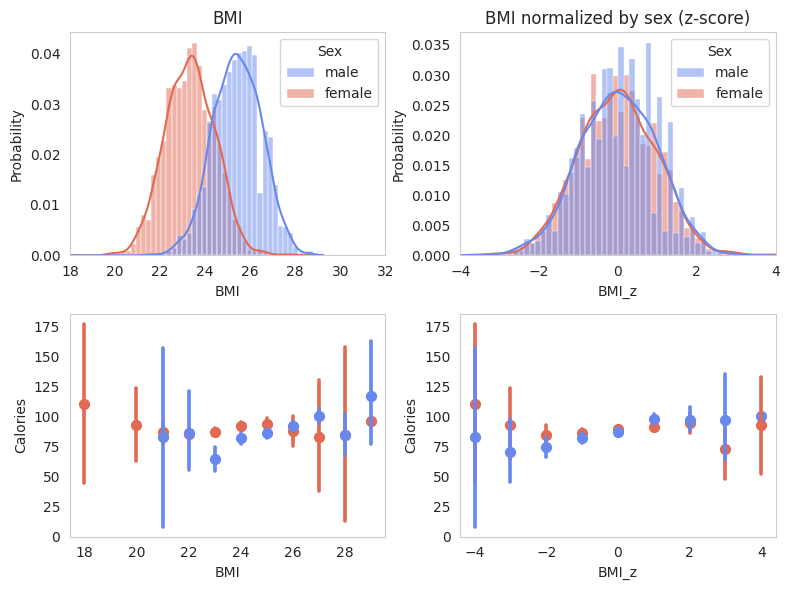

In [9]:
# Calculate the BMI and take a subset for plotting
df_train["BMI"] = df_train["Weight"] / (df_train["Height"]/100)**2
bmi_stats = df_train.groupby("Sex")["BMI"].agg(["mean", "std"]).to_dict("index")

def normalize_bmi(row):
    stats = bmi_stats.get(row["Sex"])
    if stats is not None and stats["std"] != 0:
        return (row["BMI"] - stats["mean"]) / stats["std"]
    else:
        return 0 # No misisng values but anyway

# Normaize by sex
df_train["BMI_z"] = df_train.apply(normalize_bmi, axis=1)

# Make df_subset
df_subset = df_train.sample(frac=1e-2, random_state=2025)
df_subset_female = df_subset[df_subset["Sex"]=="female"]
df_subset_male = df_subset[df_subset["Sex"]=="male"]

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
sns.set_style("whitegrid", {'axes.grid' : False})

# 1. BMI by sex
sns.histplot(x=df_subset["BMI"], 
             hue=df_subset["Sex"], palette=colors_2,
             ax=axes[0],
             kde=True,
             stat="probability")
axes[0].set_xlim(18, 32)
axes[0].set_title("BMI")

sns.regplot(x=df_subset_female["BMI"], y=df_subset_female["Calories"], order=1,
            x_bins = np.arange(16, 32, 1), fit_reg=False, 
            color=colors_2[1], ax=axes[2], label="Female")
sns.regplot(x=df_subset_male["BMI"], y=df_subset_male["Calories"], order=1,
            x_bins = np.arange(16, 32, 1), fit_reg=False, 
            color=colors_2[0], ax=axes[2], label="Male")

# 2. BMI z-score by sex
sns.histplot(x=df_subset["BMI_z"], 
             hue=df_subset["Sex"], palette=colors_2,
             ax=axes[1],
             kde=True,
             stat="probability")
axes[1].set_xlim(-4, 4)
axes[1].set_title("BMI normalized by sex (z-score)")

sns.regplot(x=df_subset_female["BMI_z"], y=df_subset_female["Calories"], order=1,
            x_bins = np.arange(-4, 5, 1), fit_reg=False, 
            color=colors_2[1], ax=axes[3], label="Female")
sns.regplot(x=df_subset_male["BMI_z"], y=df_subset_male["Calories"], order=1,
            x_bins = np.arange(-4, 5, 1), fit_reg=False, 
            color=colors_2[0], ax=axes[3], label="Male")

plt.tight_layout()
plt.show()

## 👵 Age and Caloric Expenditure
Taking a closer look at Age, we observe a general upward trend in calories burned as age increases. This could reflect differences in workout types, intensity preferences, or metabolic changes across age groups. However, this relationship is accompanied by high variance.

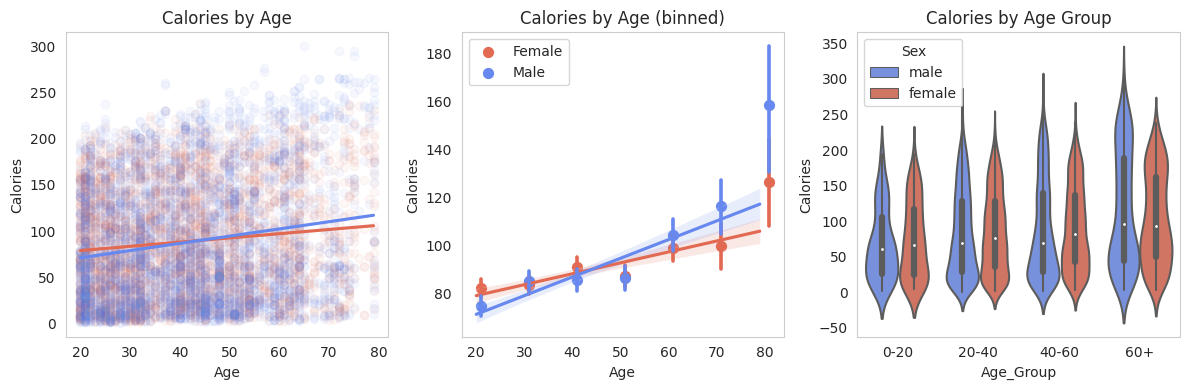

In [10]:
df_train['Age_Group'] = pd.cut(df_train['Age'], bins=[0, 20, 40, 60, 100], labels=["0-20", "20-40", "40-60", "60+"])
df_subset = df_train.sample(frac=1e-2, random_state=2025)
df_subset_female = df_subset[df_subset["Sex"]=="female"]
df_subset_male = df_subset[df_subset["Sex"]=="male"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.regplot(x=df_subset_female["Age"], y=df_subset_female["Calories"], order=1,
            color=colors_2[1], ax=axes[0],
            scatter_kws=dict(alpha=0.05), ci=None)
sns.regplot(x=df_subset_male["Age"], y=df_subset_male["Calories"], order=1,
            color=colors_2[0], ax=axes[0],
            scatter_kws=dict(alpha=0.05), ci=None)
axes[0].set_title("Calories by Age")

sns.regplot(x=df_subset_female["Age"], y=df_subset_female["Calories"], order=1,
            x_bins = np.arange(1, 100, 10), 
            color=colors_2[1], ax=axes[1], label="Female")
sns.regplot(x=df_subset_male["Age"], y=df_subset_male["Calories"], order=1,
            x_bins = np.arange(1, 100, 10), 
            color=colors_2[0], ax=axes[1], label="Male")
axes[1].legend()
axes[1].set_title("Calories by Age (binned)")

sns.violinplot(x=df_subset["Age_Group"], y=df_subset["Calories"],
               hue=df_subset["Sex"],
              palette=colors_2,
              ax=axes[2])
axes[2].set_title("Calories by Age Group")

plt.tight_layout()
plt.show()

## 🔄 Feature Interactions
To capture more complex dependencies in the data, we examine several feature interaction pairs through scatter plots. These interactions are important candidates for feature engineering, as they may uncover predictive patterns not evident in individual features. Notably, many of these relationships show clear non-linear relationships.

🔍 These interaction patterns will be incorporated into the modeling pipeline either as engineered features or left to be captured directly by flexible learners.

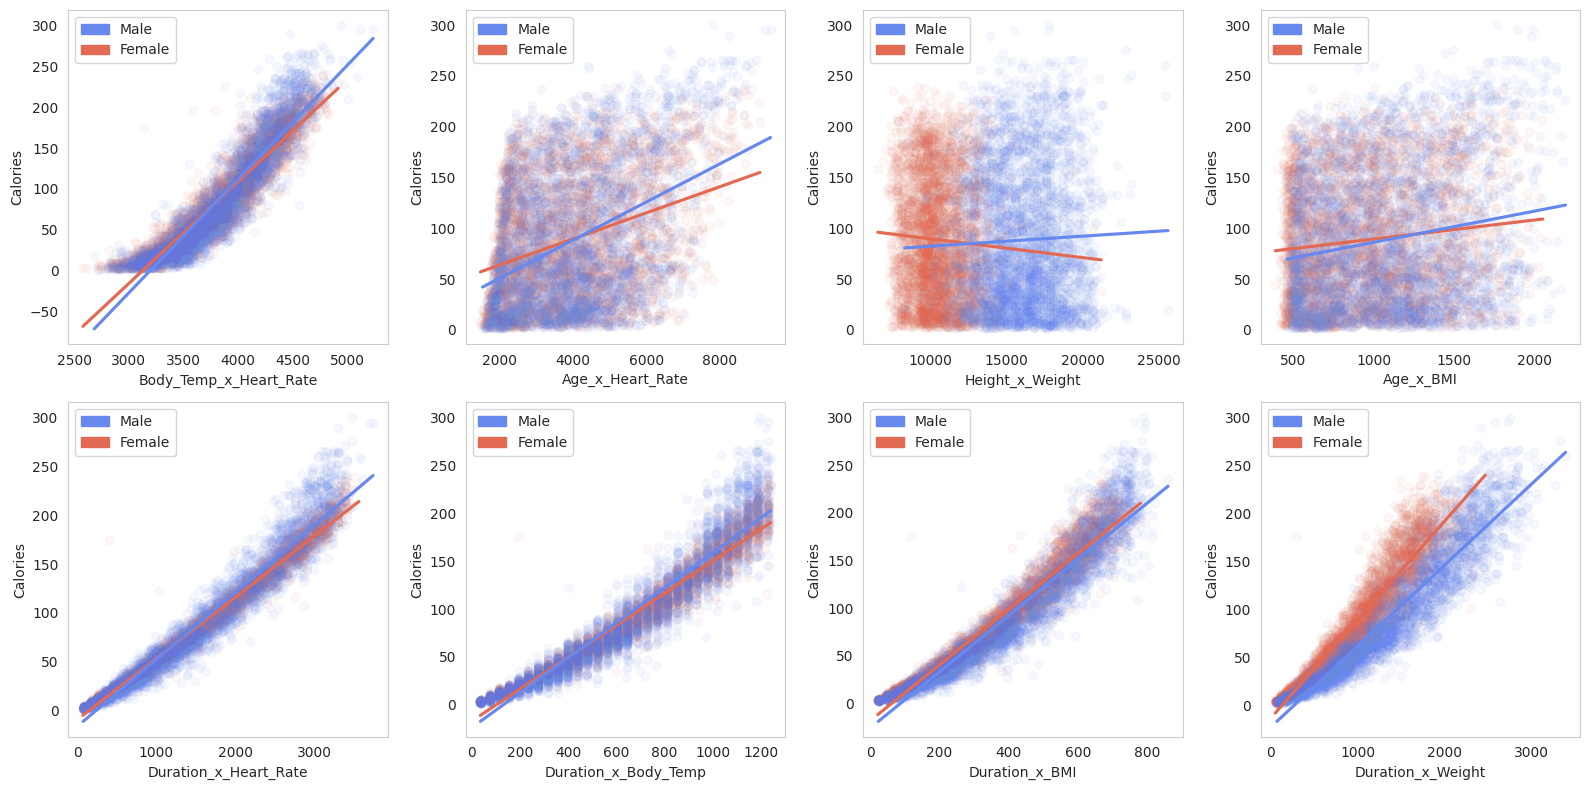

In [11]:
import matplotlib.patches as mpatches

# Calculate all interaction pairs
df_train["Body_Temp_x_Heart_Rate"] = df_train["Body_Temp"] * df_train["Heart_Rate"]
df_train["Age_x_Heart_Rate"] = df_train["Age"] * df_train["Heart_Rate"]
df_train["Height_x_Weight"] = df_train["Height"] * df_train["Weight"]
df_train["Age_x_BMI"] = df_train["Age"] * df_train["BMI"]
df_train["Duration_x_Heart_Rate"] = df_train["Duration"] * df_train["Heart_Rate"]
df_train["Duration_x_Body_Temp"] = df_train["Duration"] * df_train["Body_Temp"]
df_train["Duration_x_BMI"] = df_train["Duration"] * df_train["BMI"]
df_train["Duration_x_Weight"] = df_train["Duration"] * df_train["Weight"]

cols_interaction = df_train.columns[df_train.columns.str.contains("_x_")]

# Make df_subset
df_subset = df_train.sample(frac=1e-2, random_state=2025)
df_subset_female = df_subset[df_subset["Sex"]=="female"]
df_subset_male = df_subset[df_subset["Sex"]=="male"]

# Make figure
fig, axes = plt.subplots(2, 4, figsize=(16,8))
axes = axes.flatten()

for i, col in enumerate(cols_interaction):
    sns.regplot(x=df_subset_female[col], y=df_subset_female["Calories"], order=1,
            color=colors_2[1], ax=axes[i],
            scatter_kws=dict(alpha=0.05), ci=None, label="Female")
    sns.regplot(x=df_subset_male[col], y=df_subset_male["Calories"], order=1,
            color=colors_2[0], ax=axes[i],
            scatter_kws=dict(alpha=0.05), ci=None, label="Male")

    # Set legend markers to alpha=1
    female_patch = mpatches.Patch(color=colors_2[1], label="Female")
    male_patch = mpatches.Patch(color=colors_2[0], label="Male")
    axes[i].legend(handles=[male_patch, female_patch])

plt.tight_layout()
plt.show()

# 🛠️ Data Preprocessing Pipelines
In this section, I define the data preprocessing pipelines tailored to the requirements of different model types. Given the diversity of models used—ranging from linear models to tree-based and neural networks—each type benefits from a slightly different preprocessing approach:

**Linear Models & Neural Networks**:
These models are sensitive to feature scaling and linear relationships. For these, I apply:
- Standard scaling for all numeric features
- One-hot encoding for categorical variables

**Tree-Based Models (XGBoost, LightGBM, CatBoost)**:
These models are generally robust to feature scaling and can natively handle categorical variables (especially CatBoost). For tree models, the preprocessing is lighter:
- No scaling
- No label encoding

Inclusion of selected engineered features based on earlier EDA

⚙️ All pipelines are built using scikit-learn’s Pipeline APIs, enabling modular, consistent, and reproducible preprocessing across models.




In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_features=True, add_duration_interactions=True):
        self.add_features = add_features
        self.add_duration_interactions = add_duration_interactions

    
    def fit(self, X, y=None):
        X_copy = X.copy()

        # Calculate BMI (mean and sd for normalization)
        X_copy["BMI"] = X_copy["Weight"] / (X_copy["Height"]/100)**2
        self.bmi_stats = X_copy.groupby("Sex")["BMI"].agg(["mean", "std"]).to_dict("index")
        
        return self

    
    def transform(self, X):
        X_copy = X.copy()

        if self.add_features:
            # BMI normalized
            X_copy["BMI"] = X_copy["Weight"] / (X_copy["Height"]/100)**2
            X_copy["BMI_z"] = X_copy.apply(self.normalize_bmi, axis=1)

            # Binary features
            X_copy['Temp_Binary'] = np.where(X_copy['Body_Temp'] <= 39.5, 0, 1).astype(str)
            X_copy['HeartRate_binary'] = np.where(X_copy['Heart_Rate'] <= 99.5, 0, 1).astype(str)
    
            # Age groups
            X_copy['Age_Group'] = pd.cut(X_copy['Age'], bins=[0, 20, 35, 50, 100], labels=[0, 1, 2, 3])
    
            # Interaction pairs
            X_copy["Body_Temp_x_Heart_Rate"] = X_copy["Body_Temp"] * X_copy["Heart_Rate"]
            X_copy["Age_x_Heart_Rate"] = X_copy["Age"] * X_copy["Heart_Rate"]
            X_copy["Height_x_Weight"] = X_copy["Height"] * X_copy["Weight"]
            X_copy["Age_x_BMI"] = X_copy["Age"] * X_copy["BMI"]
            if self.add_duration_interactions:
                X_copy["Duration_x_Heart_Rate"] = X_copy["Duration"] * X_copy["Heart_Rate"]
                X_copy["Duration_x_Body_Temp"] = X_copy["Duration"] * X_copy["Body_Temp"]
                X_copy["Duration_x_BMI"] = X_copy["Duration"] * X_copy["BMI"]
                X_copy["Duration_x_Weight"] = X_copy["Duration"] * X_copy["Weight"]
                
        return X_copy

    
    def normalize_bmi(self, row):
        stats = self.bmi_stats.get(row["Sex"])
        if stats is not None and stats["std"] != 0:
            return (row["BMI"] - stats["mean"]) / stats["std"]
        else:
            return 0 # No misisng values but anyway
        

In [14]:
from sklearn.preprocessing import OneHotEncoder

class GeneralPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=None, onehot=False):
        self.scaler = scaler
        self.onehot = onehot
        
        self.num_cols = None # store numeric col names
        self.cat_cols = None# store categorical col names
        

    def fit(self, X, y=None):
        X_copy = X.copy()

        # Identify column types
        self.num_cols = X_copy.select_dtypes(include=["number"]).columns.tolist()
        self.cat_cols = X_copy.select_dtypes(include=["object", "category"]).columns.tolist()

        # Fit scaler
        if self.scaler:
            self.scaler.fit(X_copy[self.num_cols])


        # Fit OneHotEncoder
        if self.onehot:
            self.onehot_encoder = OneHotEncoder(sparse_output=False) 
            self.onehot_encoder.fit(X_copy[self.cat_cols])
        
        return self

    
    def transform(self, X):
        X_copy = X.copy()

        # Scale numerical features
        if self.scaler:
            X_copy[self.num_cols] = self.scaler.transform(X_copy[self.num_cols])

        # Encode categorical features
        if self.onehot:
           cat_encoded = self.onehot_encoder.transform(X_copy[self.cat_cols])
           cat_encoded_df = pd.DataFrame(
               cat_encoded,
               columns=self.onehot_encoder.get_feature_names_out(self.cat_cols),
               index=X_copy.index
           )
           X_copy = X_copy.drop(columns=self.cat_cols)
           X_copy = pd.concat([X_copy, cat_encoded_df], axis=1)
        else:
            X_copy[self.cat_cols] = X_copy[self.cat_cols].astype("category")

        return X_copy

In [15]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_remove):
        self.features_to_remove = features_to_remove

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        features_to_keep = [col for col in X_copy.columns if col not in self.features_to_remove]
        return X_copy[features_to_keep]  

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

features_to_remove = ["id", "Calories"]

# Baseline xgb model without feature engineering
preprocessor_baseline = Pipeline(steps = [
    ("feature_engineering", AttributeAdder(add_features=False, add_duration_interactions=False)),
    ("general_processing", GeneralPreprocessor(scaler=None, onehot=False)),
    ("feature_selection", FeatureSelector(features_to_remove))
])

# Models with feature engineering
preprocessor_fe = Pipeline(steps = [
    ("feature_engineering", AttributeAdder(add_features=True, add_duration_interactions=True)),
    ("general_processing", GeneralPreprocessor(scaler=None, onehot=False)),
    ("feature_selection", FeatureSelector(features_to_remove))
])

# Model with Cals/min as target
preprocessor_cals_min = Pipeline(steps = [
    ("feature_engineering", AttributeAdder(add_features=True, add_duration_interactions=False)),
    ("general_processing", GeneralPreprocessor(scaler=None, onehot=False)),
    ("feature_selection", FeatureSelector(features_to_remove))
])

# For NN (scaling and encoding)
preprocessor_NN = Pipeline(steps = [
    ("feature_engineering", AttributeAdder(add_features=True, add_duration_interactions=True)),
    ("general_processing", GeneralPreprocessor(scaler=StandardScaler(), onehot=True)),
    ("feature_selection", FeatureSelector(features_to_remove))
])

# For linear regression (scaling and encoding)
preprocessor_LR = Pipeline(steps = [
    ("feature_engineering", AttributeAdder(add_features=False, add_duration_interactions=False)),
    ("general_processing", GeneralPreprocessor(scaler=StandardScaler(), onehot=True)),
    ("feature_selection", FeatureSelector(features_to_remove))
])

In [17]:
# Quick test data processing pipeline
df_train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")

df_train_transformed = preprocessor_NN.fit_transform(df_train)
df_train_transformed.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,BMI_z,Body_Temp_x_Heart_Rate,Age_x_Heart_Rate,Height_x_Weight,Age_x_BMI,Duration_x_Heart_Rate,Duration_x_Body_Temp,Duration_x_BMI,Duration_x_Weight,Sex_female,Sex_male,Temp_Binary_0,Temp_Binary_1,HeartRate_binary_0,HeartRate_binary_1,Age_Group_0,Age_Group_1,Age_Group_2,Age_Group_3
0,-0.357192,1.115235,0.490201,1.266324,0.583714,1.235772,-0.939009,-2.245377,0.713096,-0.211402,0.645233,-0.483217,1.162994,1.288292,1.074067,1.449912,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.487943,-0.912137,-1.083172,-0.888309,-1.109436,-0.431163,-1.185799,-0.682904,-1.037035,0.975081,-1.032974,1.110729,-0.923974,-0.889529,-0.949655,-1.005217,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.631273,-1.068088,-0.797104,-1.008011,-1.215258,-0.302938,0.208818,1.204448,-1.108502,0.214785,-0.879182,0.631474,-1.022639,-1.003018,-0.987723,-1.052774,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.411555,1.349162,1.062337,1.146622,1.007002,0.851095,0.025968,-0.910206,1.015630,-1.221624,1.168241,-1.354053,1.161922,1.147159,1.139730,1.625278,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.225397,-0.678209,-1.011655,1.146622,0.689536,0.722869,-1.480887,-1.082251,0.713552,-0.053555,-0.931424,-0.445122,1.081489,1.139884,0.862890,0.547816,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


# 📉 Loss Functions: RMSLE
Since the competition is evaluated using Root Mean Squared Logarithmic Error (RMSLE), it’s important to use a consistent loss function during training and evaluation across all models.

To ensure consistency across model types, I define two RMSLE implementations:
- PyTorch Version: Used as a custom loss function in the neural network model, implemented using torch.nn.Module
- Scikit-learn-Compatible Version: Used for training and evaluating other models, compatible with metrics and scoring functions in sklear

In [18]:
# Loss function for NN

class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        # Add 1 to avoid log(0); ensure no negatives using torch.clamp()
        log_pred = torch.log1p(torch.clamp(y_pred, min=0))
        log_true = torch.log1p(torch.clamp(y_true, min=0))
        return torch.sqrt(self.mse(log_pred, log_true))

loss_func = RMSLELoss()

In [19]:
from sklearn.metrics import mean_squared_log_error

# Loss function for xgb and related models
def rmsle(y_true, y_pred):
    y_pred = np.clip(y_pred, 0, max(y_pred)) # clip negative values!
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Helper functions and KFold for model training

In [20]:
# Learning rate scheduler
import xgboost as xgb

class CustomLRScheduler(xgb.callback.TrainingCallback):
    def __init__(self, factor=0.5, patience=20, min_lr=1e-3, start_lr=0.1, metric="rmse"):
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.start_lr = start_lr
        self.wait = 0
        self.best_score = float("inf")
        self.current_lr = start_lr
        self.metric = metric

    def before_training(self, model):
        model.set_param("learning_rate", self.current_lr)
        return model

    def after_iteration(self, model, epoch, evals_log):
        score = evals_log["validation_0"][self.metric][-1]
        if score < self.best_score:
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.current_lr * self.factor, self.min_lr)
                if new_lr < self.current_lr:
                    print(f"Reducing learning rate to {new_lr:.6f}")
                    self.current_lr = new_lr
                    model.set_param("learning_rate", self.current_lr)
                self.wait = 0
        return False


In [21]:
# Training function
def fit_predict_KFold_xgb(model, kf, train_df, test_df, preprocessor, is_log=False, metric="rmsle"):

    # Initialize 
    oof = np.zeros(len(train_df)) # Out-of_fold predictions
    log_preds = [] # predictions on test set

    # Extract X and y
    X = train_df.drop(columns = ["Calories", "id"]).copy()
    y = train_df["Calories"].copy()
    
    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):

        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)
    
        # Training data
        X_train = X.iloc[train_index, :]
        X_train_transformed = preprocessor.fit_transform(X_train)
        y_train = y.iloc[train_index]
        if is_log:
            y_train = np.log1p(y_train)

        # Validation data
        X_val = X.iloc[val_index, :]
        X_val_transformed = preprocessor.transform(X_val)
        y_val = y.iloc[val_index]
        if is_log:
            y_val = np.log1p(y_val)
        
        # Test data
        X_test_transformed = preprocessor.transform(test_df)

        # Set callbacks
        model.set_params(callbacks=[
            EarlyStopping(rounds=100, save_best=True),
            CustomLRScheduler(factor=0.5, patience=20, min_lr=1e-3, start_lr=0.1, metric=metric),
        ])
        
        # Fit model
        model.fit(
            X_train_transformed, y_train,
            eval_set=[(X_val_transformed, y_val)],
            verbose=200,
        )

        # Inner oof (out-of-fold predictions)
        oof[val_index] += model.predict(X_val_transformed)
        # Inner test (test predictions)
        preds = model.predict(X_test_transformed)
        if is_log:
            log_preds.append(preds)
        else:
            log_preds_k = [np.log1p(p) for p in preds] # Transform to log(1+p) space
            log_preds.append(log_preds_k) # Inplace operation returns None!

        
    # Calculate average predictions on test set
    log_preds_stack = np.stack(log_preds, axis=0)
    avg_log_preds = np.average(log_preds_stack, axis=0)
    final_preds = np.expm1(avg_log_preds)

    # Inverse transform oof predictions if is_log
    if is_log:
        final_oof = np.expm1(oof)
    else:
        final_oof = oof

    return final_oof, final_preds


In [22]:
# Set up KFold and load data
from sklearn.model_selection import KFold

FOLDS = 3
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=2025)

# Load data
df_train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")

# Training of base models

## 🏋️ Training the Baseline XGBoost Model
For the baseline model, we start with a simple XGBoost implementation, without feature engineering, to establish a performance benchmark. The main goal is to evaluate how the model performs with raw features and minimal preprocessing.

We will progressively reduce the learning rate when the validation metric (RMSLE) plateaus, using a learning rate scheduler, as outlined previously. This approach helps in fine-tuning the model without overfitting.

In [23]:
from xgboost.callback import EarlyStopping

# Model
params = {'max_depth': 6, 
          'learning_rate': 0.1, 
          'n_estimators': 2000, 
          'subsample': 0.8, 
          'colsample_bytree': 0.6,
          'min_child_weight': 40, 
          'enable_categorical': True,
          'eval_metric':'rmsle'}

model_base = xgb.XGBRegressor(**params)

oof_base, pred_base = fit_predict_KFold_xgb(model_base, kf, df_train, df_test, preprocessor_baseline, is_log=False, metric="rmsle")  

####################################################################################################
### Fold 1
####################################################################################################
[0]	validation_0-rmsle:0.96532
[200]	validation_0-rmsle:0.06614
Reducing learning rate to 0.050000
Reducing learning rate to 0.025000
[400]	validation_0-rmsle:0.06485
Reducing learning rate to 0.012500
Reducing learning rate to 0.006250
[600]	validation_0-rmsle:0.06481
Reducing learning rate to 0.003125
Reducing learning rate to 0.001563
[800]	validation_0-rmsle:0.06480
[1000]	validation_0-rmsle:0.06479
[1200]	validation_0-rmsle:0.06478
[1400]	validation_0-rmsle:0.06477
Reducing learning rate to 0.001000
[1600]	validation_0-rmsle:0.06476
[1800]	validation_0-rmsle:0.06476
[1999]	validation_0-rmsle:0.06475
####################################################################################################
### Fold 2
###############################################################

## 🏋️ Training XGBoost Model with Feature Engineering
After establishing a baseline with the initial XGBoost model, we now incorporate feature engineering to enhance predictive performance. This includes the addition of interaction features and BMI.

In [24]:
model_fe = xgb.XGBRegressor(**params)

oof_fe, pred_fe = fit_predict_KFold_xgb(model_fe, kf, df_train, df_test, preprocessor_fe, is_log=False, metric="rmsle")  

####################################################################################################
### Fold 1
####################################################################################################
[0]	validation_0-rmsle:0.96486
Reducing learning rate to 0.050000
[200]	validation_0-rmsle:0.06764
[400]	validation_0-rmsle:0.06599
Reducing learning rate to 0.025000
Reducing learning rate to 0.012500
[600]	validation_0-rmsle:0.06549
Reducing learning rate to 0.006250
Reducing learning rate to 0.003125
Reducing learning rate to 0.001563
[646]	validation_0-rmsle:0.06549
####################################################################################################
### Fold 2
####################################################################################################
[0]	validation_0-rmsle:0.96641
Reducing learning rate to 0.050000
[200]	validation_0-rmsle:0.06557
[400]	validation_0-rmsle:0.06418
[600]	validation_0-rmsle:0.06349
Reducing learning rate to 0.025000
[

## 🏋️ XGBoost Model with Log-Transformed Target
For this iteration, we train the XGBoost model using the log-transformed target (calories) but evaluate using RMSE instead of RMSLE. The model still incorporates feature engineering.

In [25]:
params = {'max_depth': 6, 
          'learning_rate': 0.1, 
          'n_estimators': 2000, 
          'subsample': 0.8, 
          'colsample_bytree': 0.6,
          'min_child_weight': 40, 
          'enable_categorical': True,
          'eval_metric':'rmse'} # rmse metric as target already log transformed!

model_log = xgb.XGBRegressor(**params)

oof_log, pred_log = fit_predict_KFold_xgb(model_log, kf, df_train, df_test, preprocessor_fe, is_log=True, metric="rmse")  

####################################################################################################
### Fold 1
####################################################################################################
[0]	validation_0-rmse:0.86824
[200]	validation_0-rmse:0.06235
Reducing learning rate to 0.050000
[400]	validation_0-rmse:0.06207
Reducing learning rate to 0.025000
Reducing learning rate to 0.012500
[600]	validation_0-rmse:0.06203
Reducing learning rate to 0.006250
Reducing learning rate to 0.003125
Reducing learning rate to 0.001563
[800]	validation_0-rmse:0.06202
Reducing learning rate to 0.001000
[1000]	validation_0-rmse:0.06202
[1200]	validation_0-rmse:0.06202
[1400]	validation_0-rmse:0.06202
[1600]	validation_0-rmse:0.06201
[1800]	validation_0-rmse:0.06201
[1999]	validation_0-rmse:0.06201
####################################################################################################
### Fold 2
##########################################################################

## 🏋️ XGBoost Model with Calories per Minute as Target
In this version, we train the XGBoost model with Calories per Minute as the target to normalize for workout duration. We continue to include feature engineering (such as interaction features and BMI), but exclude all duration-related features to prevent data leakage from the target.



In [26]:
# Training function
def fit_predict_KFold_calmin(model, kf, train_df, test_df, preprocessor):

    # Initialize 
    oof = np.zeros(len(train_df)) # Out-of_fold predictions
    log_preds = [] # predictions on test set

    # Extract X and y
    X = train_df.drop(columns = ["Duration", "Calories", "id"]).copy()
    y = train_df["Calories"].copy() / train_df["Duration"].copy()
    
    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):

        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)
    
        # Training data
        X_train = X.loc[train_index, :]
        X_train_transformed = preprocessor.fit_transform(X_train)
        y_train = y.loc[train_index]

        # Validation data
        X_val = X.loc[val_index, :]
        X_val_transformed = preprocessor.transform(X_val)
        y_val = y.loc[val_index]

        # Test data
        X_test_transformed = preprocessor.transform(test_df.drop(columns = ["Duration"]).copy())

        # Set callbacks
        model.set_params(callbacks=[
            EarlyStopping(rounds=100, save_best=True),
            CustomLRScheduler(factor=0.5, patience=20, min_lr=1e-3, start_lr=0.1, metric="rmsle"),
        ])
        
        # Fit model
        model.fit(
            X_train_transformed, y_train,
            eval_set=[(X_val_transformed, y_val)],
            verbose=200,
        )

        # Inner oof (out-of-fold predictions)
        oof[val_index] += model.predict(X_val_transformed) * train_df["Duration"].loc[val_index]
        # Inner test (test predictions)
        preds = model.predict(X_test_transformed) * test_df["Duration"]
        
        log_preds_k = [np.log1p(p) for p in preds] # Transform to log(1+p) space
        log_preds.append(log_preds_k) # Inplace operation returns None!

        
    # Calculate average predictions on test set
    log_preds_stack = np.stack(log_preds, axis=0)
    avg_log_preds = np.average(log_preds_stack, axis=0)
    final_preds = np.expm1(avg_log_preds)

    return oof, final_preds

In [27]:
# Model
params = {'max_depth': 6, 
          'learning_rate': 0.1, 
          'n_estimators': 2000, 
          'subsample': 0.8, 
          'colsample_bytree': 0.6,
          'min_child_weight': 40, 
          'enable_categorical': True,
          'eval_metric':'rmsle'}


model_xgb_calmin = xgb.XGBRegressor(**params)


oof_xgb_calmin, pred_xgb_calmin = fit_predict_KFold_calmin(model_xgb_calmin, kf, df_train, df_test, preprocessor_cals_min)  

####################################################################################################
### Fold 1
####################################################################################################
[0]	validation_0-rmsle:0.21916
Reducing learning rate to 0.050000
Reducing learning rate to 0.025000
Reducing learning rate to 0.012500
Reducing learning rate to 0.006250
[191]	validation_0-rmsle:0.05353
####################################################################################################
### Fold 2
####################################################################################################
[0]	validation_0-rmsle:0.21866
Reducing learning rate to 0.050000
Reducing learning rate to 0.025000
Reducing learning rate to 0.012500
Reducing learning rate to 0.006250
[197]	validation_0-rmsle:0.05213
####################################################################################################
### Fold 3
######################################################

## 🏋️ XGBoost Models by Sex
Given the slight differences observed between sexes, including higher variance in the male data, we train two separate XGBoost models—one for males and one for females.

Both models are trained on the log-transformed target (calories) using RMSE as the evaluation metric. We maintain feature engineering, such as interaction terms and BMI, to capture relevant patterns while accounting for gender-specific differences.

When training separate XGBoost models for males and females, we notice that the validation RMSE decreases more significantly in the female model, aligning with the observed lower variance in the female data. 

In [28]:
# Model
params = {'max_depth': 6, 
          'learning_rate': 0.1, 
          'n_estimators': 2000, 
          'subsample': 0.8, 
          'colsample_bytree': 0.6,
          'min_child_weight': 40, 
          'enable_categorical': True,
          'eval_metric':'rmse'}

# Get subsets with preserved indices
# use .iloc in training function because kfold gives sequential indices but the presereved indices here are no longer sequential!
df_train_female = df_train[df_train["Sex"] == "female"]
df_train_male   = df_train[df_train["Sex"] == "male"]

df_test_female = df_test[df_test["Sex"] == "female"]
df_test_male   = df_test[df_test["Sex"] == "male"]

# Train female model
model_female = xgb.XGBRegressor(**params)
oof_female, pred_female = fit_predict_KFold_xgb(
    model_female, kf, df_train_female, df_test_female, preprocessor_fe, is_log=True, metric="rmse"
)


# Train male model
model_male = xgb.XGBRegressor(**params)
oof_male, pred_male = fit_predict_KFold_xgb(
    model_male, kf, df_train_male, df_test_male, preprocessor_fe, is_log=True, metric="rmse"
)

# OOF: create Series with proper indices and concatenate
oof_series_female = pd.Series(oof_female, index=df_train_female.index)
oof_series_male   = pd.Series(oof_male, index=df_train_male.index)

oof_full = pd.concat([oof_series_female, oof_series_male])
oof_sex = oof_full.sort_index()  # Important: restore original row order

# PRED: create Series with proper indices and concatenate
pred_series_female = pd.Series(pred_female, index=df_test_female.index)
pred_series_male   = pd.Series(pred_male, index=df_test_male.index)

pred_full = pd.concat([pred_series_female, pred_series_male])
pred_sex = pred_full.sort_index()

####################################################################################################
### Fold 1
####################################################################################################
[0]	validation_0-rmse:0.82102
Reducing learning rate to 0.050000
[200]	validation_0-rmse:0.05077
Reducing learning rate to 0.025000
Reducing learning rate to 0.012500
Reducing learning rate to 0.006250
[263]	validation_0-rmse:0.05077
####################################################################################################
### Fold 2
####################################################################################################
[0]	validation_0-rmse:0.81931
Reducing learning rate to 0.050000
Reducing learning rate to 0.025000
[200]	validation_0-rmse:0.04970
Reducing learning rate to 0.012500
Reducing learning rate to 0.006250
[244]	validation_0-rmse:0.04970
####################################################################################################
### F

## 🧳 Training CatBoost Model
Next, we train a CatBoost model using the log-transformed target (calories) and RMSE as the evaluation metric. The model incorporates the same feature engineering as previous models, including interaction features and BMI, to capture complex relationships in the data.

In [29]:
# Training function
def fit_predict_KFold_cat(model, kf, train_df, test_df, preprocessor):

    # Initialize 
    oof = np.zeros(len(train_df)) # Out-of_fold predictions
    log_preds = [] # predictions on test set

    # Extract X and y
    X = train_df.drop(columns = ["Calories", "id"]).copy()
    y = train_df["Calories"].copy()

    
    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):

        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)
    
        # Training data
        X_train = X.iloc[train_index, :]
        X_train_transformed = preprocessor.fit_transform(X_train)
        y_train = np.log1p(y.iloc[train_index])

        # Validation data
        X_val = X.iloc[val_index, :]
        X_val_transformed = preprocessor.transform(X_val)
        y_val = np.log1p(y.iloc[val_index])
        
        # Test data
        X_test_transformed = preprocessor.transform(test_df)
                
        # Fit model
        model.fit(
            X_train_transformed, y_train,
            eval_set=[(X_val_transformed, y_val)],
            verbose=50)

        # Inner oof (out-of-fold predictions)
        oof[val_index] += model.predict(X_val_transformed)
        # Inner test (test predictions)
        preds = model.predict(X_test_transformed)
        log_preds.append(preds) # Inplace operation returns None!


    # Calculate average predictions on test set
    log_preds_stack = np.stack(log_preds, axis=0)
    avg_log_preds = np.average(log_preds_stack, axis=0)
    final_preds = np.expm1(avg_log_preds)

    # Inverse transform oof predictions
    final_oof = np.expm1(oof)

    return final_oof, final_preds

In [30]:
import catboost as cb

# Get a list of the names of the categorical columns
X = df_train.drop(columns=["Calories", "id"]).copy()
X_transformed = preprocessor_fe.fit_transform(X)
cat_cols = list(X_transformed.select_dtypes(include=["object", "category"]).columns) 

cat_params = {
    'iterations': 2000,
    'depth': 10,
    'l2_leaf_reg': 5,
    #'eta': 0.05, 
    #'reg_lambda': 500, 
    'loss_function': 'RMSE', # log transform target before training!
    'early_stopping_rounds': 100,
    'cat_features': cat_cols,
}

model_cat = cb.CatBoostRegressor(**cat_params,)
oof_cat, pred_cat = fit_predict_KFold_cat(model_cat, kf, df_train, df_test, preprocessor_fe) 

####################################################################################################
### Fold 1
####################################################################################################
0:	learn: 0.9359208	test: 0.9347415	best: 0.9347415 (0)	total: 356ms	remaining: 11m 50s
50:	learn: 0.2296277	test: 0.2299308	best: 0.2299308 (50)	total: 12.8s	remaining: 8m 9s
100:	learn: 0.0844442	test: 0.0859653	best: 0.0859653 (100)	total: 25.6s	remaining: 8m 1s
150:	learn: 0.0636815	test: 0.0657728	best: 0.0657728 (150)	total: 37.9s	remaining: 7m 43s
200:	learn: 0.0608984	test: 0.0632486	best: 0.0632486 (200)	total: 49.8s	remaining: 7m 26s
250:	learn: 0.0600462	test: 0.0626342	best: 0.0626342 (250)	total: 1m 2s	remaining: 7m 15s
300:	learn: 0.0594578	test: 0.0622707	best: 0.0622707 (300)	total: 1m 14s	remaining: 7m 1s
350:	learn: 0.0590314	test: 0.0620514	best: 0.0620514 (350)	total: 1m 26s	remaining: 6m 47s
400:	learn: 0.0586707	test: 0.0618797	best: 0.0618797 (400)	total

## 🔦 Training LightGBM Model
Next, we train a LightGBM model using the log-transformed target (calories) and RMSE as the evaluation metric. As with previous models, we include feature engineering, such as interaction features and BMI, to enhance the model’s ability to capture complex relationships in the data.

In [31]:
# Training function
def fit_predict_KFold_lgbm(model, kf, train_df, test_df, preprocessor):

    # Initialize 
    oof = np.zeros(len(train_df)) # Out-of_fold predictions
    log_preds = [] # predictions on test set

    # Extract X and y
    X = train_df.drop(columns = ["Calories", "id"]).copy()
    y = train_df["Calories"].copy()
    
    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):

        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)
    
        # Training data
        X_train = X.iloc[train_index, :]
        X_train_transformed = preprocessor.fit_transform(X_train)
        y_train = np.log1p(y.iloc[train_index])

        # Validation data
        X_val = X.iloc[val_index, :]
        X_val_transformed = preprocessor.transform(X_val)
        y_val = np.log1p(y.iloc[val_index])
        
        # Test data
        X_test_transformed = preprocessor.transform(test_df)
    
        # Fit model
        model.fit(X_train_transformed, y_train,
                  eval_set=[(X_val_transformed, y_val)],
                  callbacks=[
                      early_stopping(stopping_rounds=100),
                      reset_parameter(learning_rate=lambda iter: 0.1 * (0.5 ** (iter // 500))),
                      log_evaluation(period=250)
                  ])

        # Inner oof (out-of-fold predictions)
        oof[val_index] += model.predict(X_val_transformed)
        # Inner test (test predictions)
        preds = model.predict(X_test_transformed)
        log_preds.append(preds) # Inplace operation returns None!


    # Calculate average predictions on test set
    log_preds_stack = np.stack(log_preds, axis=0)
    avg_log_preds = np.average(log_preds_stack, axis=0)
    final_preds = np.expm1(avg_log_preds)

    # Inverse transform oof predictions
    final_oof = np.expm1(oof)

    return final_oof, final_preds

In [32]:
import lightgbm as lgbm
from lightgbm import early_stopping, reset_parameter, log_evaluation

model_lgbm = lgbm.LGBMRegressor(
    n_estimators = 2000,
    learning_rate = 0.1,
    metric = 'rmse', # log transform target before training!
    max_depth = -1,
    colsample_bytree = 0.7,
    verbosity = -1,
)

oof_lgbm, pred_lgbm = fit_predict_KFold_lgbm(model_lgbm, kf, df_train, df_test, preprocessor_fe) 

####################################################################################################
### Fold 1
####################################################################################################
Training until validation scores don't improve for 100 rounds
[250]	valid_0's rmse: 0.0623413
[500]	valid_0's rmse: 0.0619403
[750]	valid_0's rmse: 0.0618781
[1000]	valid_0's rmse: 0.0618447
[1250]	valid_0's rmse: 0.0618192
Early stopping, best iteration is:
[1219]	valid_0's rmse: 0.0618178
####################################################################################################
### Fold 2
####################################################################################################
Training until validation scores don't improve for 100 rounds
[250]	valid_0's rmse: 0.0607027
[500]	valid_0's rmse: 0.0603672
Early stopping, best iteration is:
[640]	valid_0's rmse: 0.0602995
#########################################################################################

## 📊 Training Linear Regression Model
For the Linear Regression model, we train it without any feature engineering, relying solely on the raw features. However, we apply scaling to the numeric features and encoding to the categorical features to ensure compatibility with the linear model.

This approach serves as a simple baseline model, providing insights into the predictive power of the raw features without additional complexity.

In [33]:
# Training function
def fit_predict_KFold_LR(model, kf, train_df, test_df, preprocessor):

    # Initialize 
    oof = np.zeros(len(train_df)) # Out-of_fold predictions
    log_preds = [] # predictions on test set

    # Extract X and y
    X = train_df.drop(columns = ["Calories", "id"]).copy()
    y = train_df["Calories"].copy()
    
    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):

        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)
    
        # Training data
        X_train = X.iloc[train_index, :]
        X_train_transformed = preprocessor.fit_transform(X_train)
        y_train = np.log1p(y.iloc[train_index])

        # Validation data
        X_val = X.iloc[val_index, :]
        X_val_transformed = preprocessor.transform(X_val)
        y_val = np.log1p(y.iloc[val_index])
        
        # Test data
        X_test_transformed = preprocessor.transform(test_df)
    
        # Fit model
        model.fit(X_train_transformed, y_train)

        # Inner oof (out-of-fold predictions)
        oof[val_index] += model.predict(X_val_transformed)
        # Inner test (test predictions)
        preds = model.predict(X_test_transformed)
        log_preds.append(preds) # Inplace operation returns None!


    # Calculate average predictions on test set
    log_preds_stack = np.stack(log_preds, axis=0)
    avg_log_preds = np.average(log_preds_stack, axis=0)
    final_preds = np.expm1(avg_log_preds)

    # Inverse transform oof predictions
    final_oof = np.expm1(oof)

    return final_oof, final_preds

In [34]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
oof_LR, pred_LR = fit_predict_KFold_LR(model_LR, kf, df_train, df_test, preprocessor_LR) 

####################################################################################################
### Fold 1
####################################################################################################
####################################################################################################
### Fold 2
####################################################################################################
####################################################################################################
### Fold 3
####################################################################################################


## 🤖 Training Neural Network (MLP)
We train a simple Multilayer Perceptron (MLP) neural network using PyTorch. This model leverages feature engineering (such as interaction features and BMI), along with scaling for numeric features and encoding for categorical features to ensure compatibility.

The MLP architecture is kept simple with a few dense layers, making it a flexible model capable of capturing non-linear relationships in the data.

In [35]:
# Custom DataSet

from torch.utils.data import Dataset

class CaloriesDataset(Dataset):
    def __init__(self, X_nums, y=None): # Pass in DataFrames, only numeric data!
        self.X_nums = torch.tensor(X_nums.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1) if y is not None else None # None for test set
    
    def __len__(self): # Return length
        return len(self.X_nums)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X_nums[idx], self.y[idx]
        else: 
            return self.X_nums[idx]

In [36]:
# Define model

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes=[64, 32]):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_sizes[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.BatchNorm1d( hidden_sizes[1]),
            nn.Linear(hidden_sizes[1], 1)  # regression output
        )

    def forward(self, x):
        return self.layers(x)

In [37]:
# Training functions

import copy
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]


def loss_batch(loss_func, yb, yb_h, device, opt=None):
    yb, yb_h = yb.to(device), yb_h.to(device)
    loss = loss_func(yb_h, yb)
    
    if opt:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item()


def loss_epoch(model, loss_func, dataset_loader, device, opt=None):
    loss = 0.
    len_data = len(dataset_loader) # number of batches
    
    for xb, yb in dataset_loader: # loop over batches
        xb, yb = xb.to(device), yb.to(device)
        yb_h = model(xb) # forward pass
        loss_b = loss_batch(loss_func, yb, yb_h, device, opt)
        loss += loss_b
        
    loss /= len_data
    return loss


def train_val(model, params):
    # Unpack parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    lr_scheduler = params["lr_scheduler"]
    device = params["device"]

    # History of loss values
    loss_history={"train": [],"val": []}
    # Deep copy of best model
    best_model_wts = copy.deepcopy(model.state_dict())
    # Initialize best loss to a large value
    best_loss = float('inf')

    # Main loop
    for epoch in range(num_epochs):

        # Get learning rate
        current_lr  = get_lr(opt)
        print(f"epoch:{epoch}, learning rate: {current_lr}")

        # Training
        model.train()
        train_loss = loss_epoch(model, loss_func, train_dl, device, opt)
        # Collect loss value
        loss_history["train"].append(train_loss)
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, device)
        # Collect loss value
        loss_history["val"].append(val_loss)

        # Store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print("Copied best model weights!")

        # Learning rate schedule
        lr_scheduler.step(val_loss)
        #if current_lr != get_lr(opt): # Re-start training with last best model
            #print("loading best model weights!")
            #model.load_state_dict(best_model_wts)

        print(f"train loss: {train_loss}, val loss: {val_loss}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history


def fit_predict_NN_kFold(kf, params):
    # Unpack parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    train_df = params["train_df"]
    test_df = params["test_df"]
    preprocessor = params["preprocessor"]

    # Initialize 'oof' and 'pred' to store the predictions
    oof = np.zeros(len(train_df))
    pred = np.zeros(len(test_df))

    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):
    
        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # Split features and targets training set
        X = train_df.drop(columns=["Calories"]).copy()
        y = train_df["Calories"].copy()

        # Split and prepare training and validataion data
        X_train = X.loc[train_index, :]
        X_train = preprocessor.fit_transform(X_train)
        y_train = y.loc[train_index].copy()
        train_dataset = CaloriesDataset(X_train, y_train)
        train_dl = DataLoader(train_dataset, batch_size=1024, shuffle=True)

        X_val = X.loc[val_index, :]
        X_val = preprocessor.transform(X_val)
        y_val = y.loc[val_index].copy()
        val_dataset = CaloriesDataset(X_val, y_val)
        val_dl = DataLoader(val_dataset, batch_size=1024, shuffle=False)

        # Prepare test data
        X_test = preprocessor.transform(test_df)
        test_dataset = CaloriesDataset(X_test)
        test_dl = DataLoader(test_dataset, batch_size=1024, shuffle=False)
       
        # Initialize model
        model = SimpleMLP(input_dim=X_train.shape[1])
        model.to(device) 
        
        # Prepare optimizer and learning rate schedule
        opt = optim.Adam(model.parameters(), lr=1e-2)
        lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5)
        
        # Parameters for training
        params_train = {
            "num_epochs": num_epochs,
            "optimizer": opt,
            "loss_func": loss_func,
            "train_dl": train_dl,
            "val_dl": val_dl,
            "lr_scheduler": lr_scheduler,
            "device": device,
        }
        
        # Training
        model, loss_history = train_val(model, params_train)

        # Evaluation and test predictions
        model.eval()
        with torch.no_grad():
            # Inner oof
            outputs = []
            for xb, _ in val_dl:
                xb = xb.to(device)
                out = model(xb)
                outputs.extend(out.cpu().numpy().flatten())
            oof[val_index] = outputs
            # Inner test
            outputs = []
            for xb in test_dl:
                xb = xb.to(device)
                out = model(xb)
                outputs.extend(out.cpu().numpy().flatten())
            pred += outputs
        
    # Compute average test predictions
    pred /= kf.get_n_splits()

    return oof, pred

In [38]:
# Training

params = {
    "num_epochs": 100,
    "loss_func": loss_func,
    "train_df": df_train,
    "test_df": df_test,
    "preprocessor": preprocessor_NN
}

oof_NN, pred_NN = fit_predict_NN_kFold(kf, params) 

####################################################################################################
### Fold 1
####################################################################################################
Using device: cpu
epoch:0, learning rate: 0.01
Copied best model weights!
train loss: 0.6242006141654309, val loss: 0.12068515030705199
epoch:1, learning rate: 0.01
Copied best model weights!
train loss: 0.12371058965478939, val loss: 0.07828017686094557
epoch:2, learning rate: 0.01
Copied best model weights!
train loss: 0.11670849861573344, val loss: 0.069646612007399
epoch:3, learning rate: 0.01
train loss: 0.10696847090813767, val loss: 0.09755229743159548
epoch:4, learning rate: 0.01
train loss: 0.10546184490398638, val loss: 0.07832803473788864
epoch:5, learning rate: 0.01
train loss: 0.10023006460113272, val loss: 0.09270324104902695
epoch:6, learning rate: 0.01
train loss: 0.10131628807550315, val loss: 0.07529908595036487
epoch:7, learning rate: 0.01
train loss: 0.1012

# 🧑‍🏫 Ridge Meta Model for Stacking
For the final ensemble, we train a Ridge Regression meta-model using the out-of-fold (OOF) predictions from the base models (XGBoost, CatBoost, LightGBM, Linear Regression, and Neural Network). The Ridge model combines the strengths of each base model to improve overall predictions.

To ensure valid predictions, the model outputs are clipped at 0, as negative values would be unrealistic when using the log-transformed target in the metric.

This stacking approach helps leverage the diversity of the base models and improve the final prediction accuracy.

In [39]:
from sklearn.linear_model import Ridge

# Stack oofs into a new training set
X_meta = np.column_stack([oof_base, oof_fe, oof_log, oof_xgb_calmin, oof_sex,
                          oof_cat, oof_lgbm, oof_LR, oof_NN])
X_meta = np.clip(X_meta, a_min=0, a_max=X_meta.max())
X_meta = np.log1p(X_meta) # Log transform
y_meta = np.log1p(df_train["Calories"])

# Test data
X_meta_test = np.column_stack([pred_base, pred_fe, pred_log, pred_xgb_calmin, pred_sex,
                               pred_cat, pred_lgbm, pred_LR, pred_NN])
X_meta_test = np.clip(X_meta_test, a_min=0, a_max=X_meta_test.max())
X_meta_test = np.log1p(X_meta_test)

# Initialize OOF and PRED
oof_stack = np.zeros(len(y_meta))
pred_stacked = []

# Train Ridge
for train_idx, val_idx in kf.split(X_meta):
    X_train, X_val = X_meta[train_idx], X_meta[val_idx]
    y_train, y_val = y_meta[train_idx], y_meta[val_idx]
    
    model_ridge = Ridge(alpha=1e3) 
    model_ridge.fit(X_train, y_train)
    
    oof_stack[val_idx] = model_ridge.predict(X_val)
    pred_stacked.append(model_ridge.predict(X_meta_test))

preds_stacked_stack = np.stack(pred_stacked, axis=0)
avg_log_preds = np.average(preds_stacked_stack, axis=0)
final_preds = np.expm1(avg_log_preds)

print("Stacking RMSLE:", rmsle(np.expm1(y_meta), np.expm1(oof_stack)))


Stacking RMSLE: 0.05979082940664484


In [40]:
# Prepare data for submission

result = pd.DataFrame({
    "id": df_test.id,
    "Calories": np.clip(final_preds, a_min=0, a_max=max(final_preds))
})

result.to_csv('submission.csv', index=False)

result

,id,Calories
0,750000,27.498812
1,750001,108.473580
2,750002,86.955282
3,750003,125.616521
4,750004,75.859867
...,...,...
249995,999995,25.977206
249996,999996,9.455731
249997,999997,72.920402
249998,999998,168.185321


# 📊 Performance of Base Models and Ridge Ensemble
The plot above shows the Out-of-Fold (OOF) RMSLE scores for each model. The models are sorted by their OOF performance, with the Ridge Ensemble (highlighted in red) providing a reference for the final stacked model. As expected, the Ridge Ensemble benefits from combining the predictions of the base models, showing an improvement over individual models.

The Linear Regression model performs significantly worse compared to other models. While the XGBoost, CatBoost, LightGBM, and Neural Network models provide comparable performance, the Linear Regression struggles to capture the complex relationships in the data, leading to a higher OOF RMSLE.

This suggests that the linear model might be too simplistic for this problem, while more complex models are better at capturing non-linear relationships and interactions.



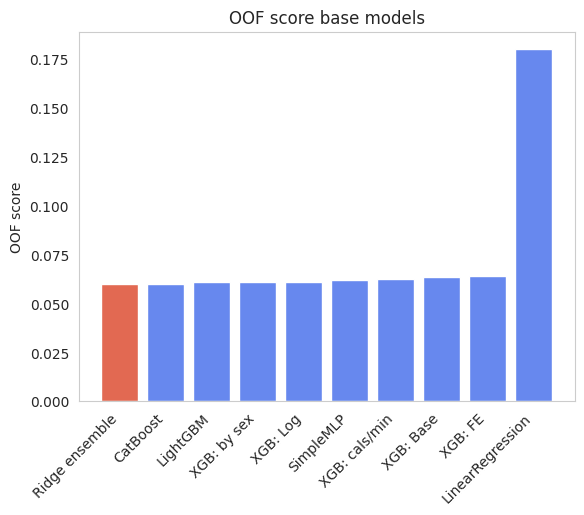

In [41]:
# Performance of base models and ridge ensemble

y_true = df_train["Calories"].copy()
df_oof_score = pd.DataFrame({"model": ["XGB: Base", "XGB: FE", "XGB: Log", "XGB: cals/min", "XGB: by sex", 
                                       "CatBoost", "LightGBM", "LinearRegression", "SimpleMLP", "Ridge ensemble"],
                             "OOF score": [rmsle(y_true, oof_base), rmsle(y_true, oof_fe), rmsle(y_true, oof_log), rmsle(y_true, oof_xgb_calmin), rmsle(y_true, oof_sex), 
                                           rmsle(y_true, oof_cat), rmsle(y_true, oof_lgbm), rmsle(y_true, oof_LR), rmsle(y_true, oof_NN),  rmsle(y_true, np.expm1(oof_stack))]})

# Sort the models by OOF score
df_oof_score_sorted = df_oof_score.sort_values("OOF score", ascending=True).reset_index()

# Create numeric x positions for sorted values
x_pos_sorted = np.arange(len(df_oof_score_sorted))

# Define a color for the Ridge model (e.g., red) and others (e.g., blue)
cmap_ = [colors_2[0]] * len(df_oof_score_sorted)
for idx in df_oof_score_sorted.index[df_oof_score_sorted['model'] == 'Ridge ensemble']:
    idx_ridge = idx
cmap_[idx] = colors_2[1]

plt.bar(x=x_pos_sorted, height=df_oof_score_sorted["OOF score"], color=cmap_)
plt.xticks(ticks=x_pos_sorted, labels=df_oof_score_sorted.model.values, rotation=45, ha='right')
plt.ylabel("OOF score")
plt.title("OOF score base models")
plt.show()

# 📊 Model Importance in the Ridge Ensemble
The model importance within the Ridge Ensemble reflects the individual performances of the base models. Notably, the Linear Regression model has minimal influence on the final predictions, which aligns with its significantly worse performance compared to the other models. On the other hand, the more powerful models, such as XGBoost, CatBoost, and LightGBM, contribute more significantly to the ensemble's predictions, enhancing overall performance.

This demonstrates how the Ridge ensemble effectively combines the strengths of the best-performing models while minimizing the impact of weaker ones like the Linear Regression model.



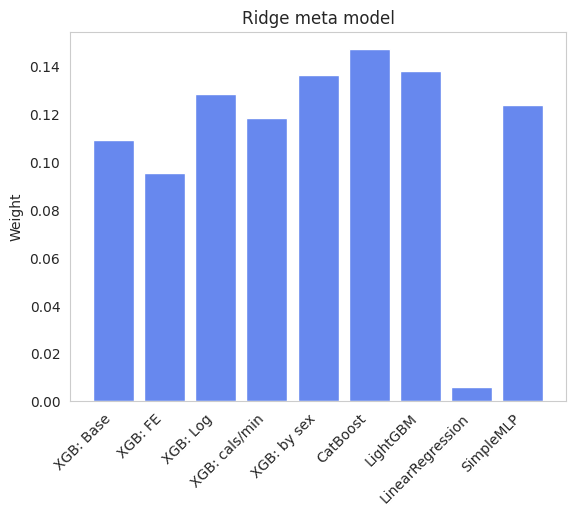

In [42]:
# Ridge: model importance
model_names = ["XGB: Base", "XGB: FE", "XGB: Log", "XGB: cals/min", "XGB: by sex", 
               "CatBoost", "LightGBM", "LinearRegression", "SimpleMLP"]

# Create numeric x positions
x_pos = np.arange(len(model_names))

plt.bar(x=x_pos, height=model_ridge.coef_, color=colors_2[0])
plt.xticks(ticks=x_pos, labels=model_names, rotation=45, ha='right')
plt.ylabel("Weight")
plt.title("Ridge meta model")
plt.show()

# 🔍 Feature Importance Across Models
The feature importance analysis reveals consistent trends across the models. As expected from the Exploratory Data Analysis (EDA), duration-related features, along with heart_rate and body_Temp, show high importance in most models. These features are critical in predicting the calories burned during workouts, as they are directly related to the intensity and effort of the activity.

However, BMI surprisingly has minimal effect on the predictions, despite being a commonly important feature in fitness-related datasets. 

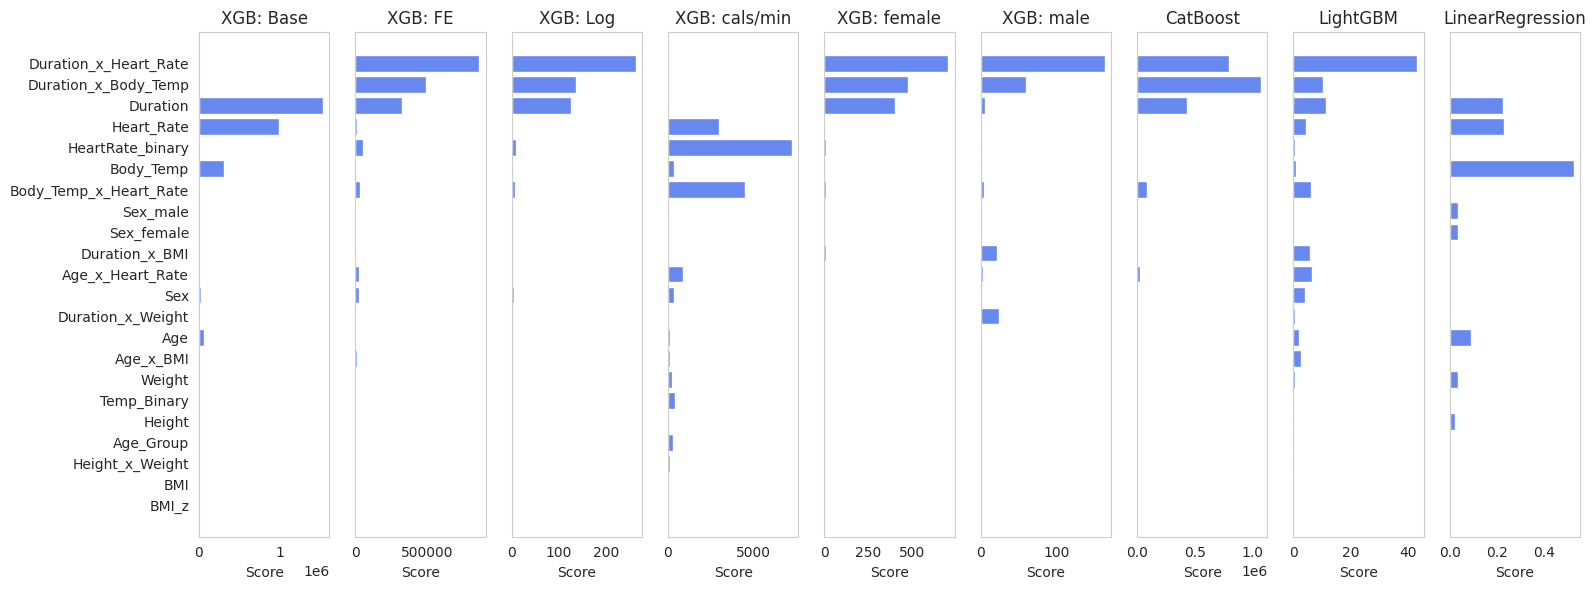

In [43]:
# Assuming your models are stored in lists:
xgb_models = [model_base, model_fe, model_log, model_xgb_calmin, model_female, model_male]
lgb_models = [model_lgbm]
cat_models = [model_cat]
lr_models = [model_LR]

importance_dfs = []

# XGBoost
for i, model in enumerate(xgb_models):
    booster = model.get_booster()
    imp = booster.get_score(importance_type='gain')
    df = pd.DataFrame.from_dict(imp, orient='index', columns=[f'xgb_{i+1}'])
    importance_dfs.append(df)

# LightGBM
for i, model in enumerate(lgb_models):
    booster = model.booster_  # access the core booster
    imp = dict(zip(booster.feature_name(), booster.feature_importance(importance_type='gain')))
    df = pd.DataFrame.from_dict(imp, orient='index', columns=[f'lgb_{i+1}'])
    importance_dfs.append(df)

# CatBoost
for i, model in enumerate(cat_models):
    importances = model.get_feature_importance()
    
    # Use model.feature_names_
    features = model.feature_names_

    imp = dict(zip(features, importances))
    df = pd.DataFrame.from_dict(imp, orient='index', columns=[f'cat_{i+1}'])
    importance_dfs.append(df)

# Linear regression
for i, model in enumerate(lr_models):

    features = model.feature_names_in_  # sklearn 1.0+

    importances = np.abs(model.coef_)
    imp = dict(zip(features, importances))
    
    df = pd.DataFrame.from_dict(imp, orient='index', columns=[f'lr_{i+1}'])
    importance_dfs.append(df)

# Merge all into one DataFrame
feature_importance_df = pd.concat(importance_dfs, axis=1, sort=True)
feature_importance_df = feature_importance_df.reset_index().rename(columns={"index": "feature"})

# Normalize each column (excluding the "Feature" column)
normalized = feature_importance_df.drop(columns="feature").apply(lambda x: x / x.sum(), axis=0)
# Compute mean normalized importance
feature_importance_df["mean_importance"] = normalized.mean(axis=1)
# Sort by mean importance
feature_importance_df = feature_importance_df.sort_values(by="mean_importance", ascending=True) # Inversed during plotting
# Rename columns 
col_names =  ["Feature", "XGB: Base", "XGB: FE", "XGB: Log", "XGB: cals/min", "XGB: female",  "XGB: male", 
               "CatBoost", "LightGBM", "LinearRegression"]
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df.columns = col_names + ["mean_importance"]

models =  ["XGB: Base", "XGB: FE", "XGB: Log", "XGB: cals/min", "XGB: female",  "XGB: male", 
           "CatBoost", "LightGBM", "LinearRegression"]
fig, axes = plt.subplots(1, len(models), figsize=(16, 6), sharey=True)

for i, m in enumerate(models):
    axes[i].barh(feature_importance_df["Feature"], feature_importance_df[m], color=colors_2[0])
    axes[i].set_title(m)
    axes[i].set_xlabel("Score")

plt.tight_layout()
plt.show()